<IPython.core.display.Javascript object>


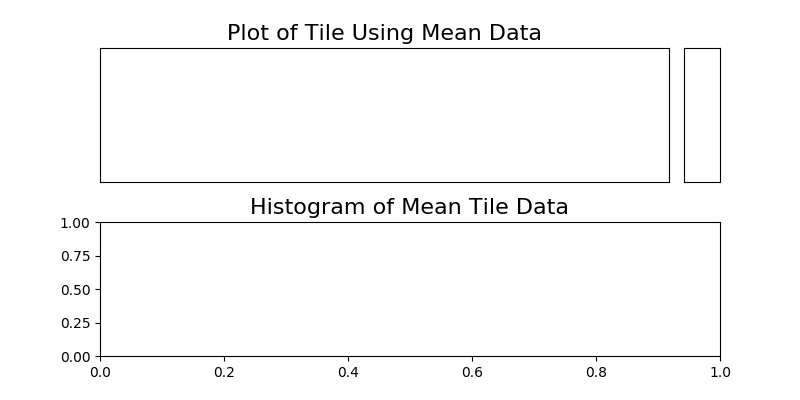

<IPython.core.display.Javascript object>


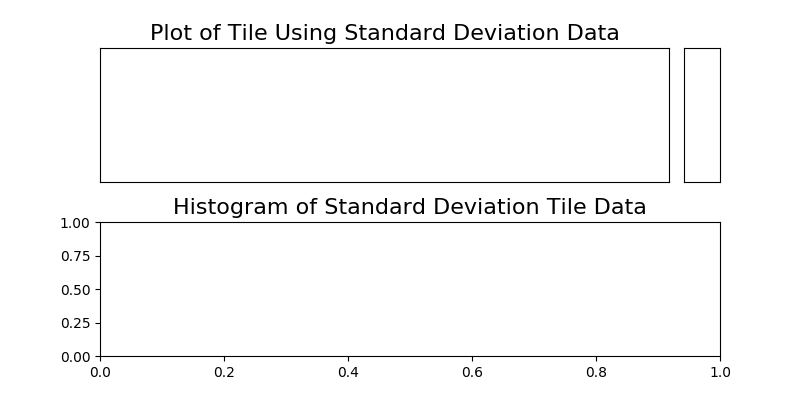

<IPython.core.display.Javascript object>


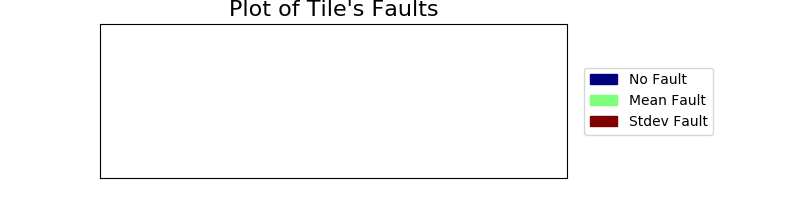

,Bad Chips,Bad Columns,Bad Pixels
Mean Total,0,0,0
Lower Than Threshold,0,0,0
Higher Than Threshold,0,0,0
Standard Deviation Total,0,0,0
Lower Than Threshold,0,0,0
Higher Than Threshold,0,0,0
Overall Total,0,0,0


In [1]:
%matplotlib notebook

import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt

import extract_data
import test_results
import fault_tiles
import test_data
import plot

# Init variables
mean_fig = None
stdev_fig = None
fault_fig = None
results_table = None

# TODO - file chooser
lpd_file_name = '/data/lpd/matt/' + 'lpdData-04765.hdf5_000001.h5'

tile_choice = widgets.RadioButtons(
    options = ['Left Tile', 'Right Tile'],
    # TODO - Remove value selection as this is just for dev. purposes
    value = 'Right Tile',
    disabled = False
)
tile_choice_label = widgets.Label(
    value = 'Tile Orientation:',
    layout = widgets.Layout(width = '25%'),
)


# Event handling for radio buttons
def on_change(change):
    # Avoid getting property lock etc.
    if change['type'] == 'change' and change['name'] == 'value':
        tile_choice.value = change['new']   

tile_choice.observe(on_change)

# Mini connector slider
mini_connector_selector = widgets.IntSlider(
    # TODO - Change default value to 1 - currently at 4 for dev. purposes
    value = 4,
    min = 1,
    max = 8,
    step = 1,
    orientation = 'horizontal'
)
mini_connector_label = widgets.Label(
    value = 'Mini Connector:',
    layout = widgets.Layout(width = '25%')
)

# Checkboxes
triggers_check = widgets.Checkbox(
    value=False,
    description='Show indivdual trigger images?',
)
first_image_check = widgets.Checkbox(
    value=False,
    description='Show first image?'
)

analyse_button = widgets.Button(
    description='Analyse Data',
    layout = widgets.Layout(width='50%')
)


# Event handling for analyse button
def on_button_clicked(b):
    analyse_data()
    
analyse_button.on_click(on_button_clicked)

# Arrange widgets into various groups so they display in a certain manner
tile_orientation_group = widgets.HBox([tile_choice_label, tile_choice], layout=widgets.Layout(height='60%'))
mini_connector_group = widgets.HBox([mini_connector_label, mini_connector_selector])
checkbox_group = widgets.VBox([triggers_check, first_image_check])
main_left_group = widgets.VBox([tile_orientation_group, analyse_button])
main_right_group = widgets.VBox([mini_connector_group, checkbox_group])

# Display widgets
display(widgets.HBox([main_left_group, main_right_group]))

# Setup figures and subplots
mean_fig, mean_tile_plot, mean_tile_colorbar, mean_histogram = plot.setup_test_plots(1)
stdev_fig, stdev_tile_plot, stdev_tile_colorbar, stdev_histogram = plot.setup_test_plots(2)
fault_fig, fault_tile_plot, fault_legend = plot.setup_fault_plots()
results_table = test_results.show_test_results([0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], results_table)

def analyse_data():
    lpd_data = extract_data.get_lpd_data(lpd_file_name)
    tile_position = extract_data.set_tile_position(tile_choice.value, mini_connector_selector.value)
    mean_tile = extract_data.get_mean_tile(lpd_data, tile_position)
    stdev_tile = extract_data.get_stdev_tile(lpd_data, tile_position)
    
    fault_tile = np.zeros((32, 128), dtype=np.int32)
    
    # Mean data test with plots of mean tile and histogram
    bad_chips_mean = test_data.bad_chips(mean_tile, fault_tile, 1)
    bad_cols_mean = test_data.bad_columns(mean_tile, fault_tile, 1)
    bad_pixels_mean = test_data.bad_pixels(mean_tile, fault_tile, 1)
    test_data.manage_figure(mean_tile, mean_tile_plot, mean_tile_colorbar, mean_histogram, 0)
    
    # Test using standard deviation data
    bad_chips_stdev = test_data.bad_chips(stdev_tile, fault_tile, 2)
    bad_cols_stdev = test_data.bad_columns(stdev_tile, fault_tile, 2)
    bad_pixels_stdev = test_data.bad_pixels(stdev_tile, fault_tile, 2)
    test_data.manage_figure(stdev_tile, stdev_tile_plot, stdev_tile_colorbar, stdev_histogram, 1)
    
    # Plotting fault image
    fault_fig = fault_tiles.plot_faults(fault_tile_plot, fault_tile)
    
    # Display bad components of tile as text
    test_results.show_test_results(bad_chips_mean, bad_chips_stdev, bad_cols_mean, bad_cols_stdev, 
                                                   bad_pixels_mean, bad_pixels_stdev, results_table)
    
    # Acting on checkbox statuses
    if triggers_check.value:
        test_results.display_trigger_images(lpd_data, tile_position)

    if first_image_check.value:
        test_results.display_first_image(lpd_data)
